In [16]:
## locate an AmeriFlux using HydroData

# import packages
import subsettools as st
import hf_hydrodata as hf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

#  change this to your email and pin
## [register PIN here](https://hydrogen.princeton.edu/pin)
#hf.gridded.register_api_pin("<your_email>", "<your_pin>")

# get info for Ameriflux sites
data_set = "ameriflux"
variable = 'latent_heat'
temporal_resolution = 'hourly'
aggregation = 'sum'


State = "TX"#NE is Nebraska can use HUC as well

# Get metadata for all sites within the sate (or region) of interest
metadata_df = hf.get_point_metadata(dataset =  data_set, variable =variable, temporal_resolution =  temporal_resolution, aggregation =aggregation,state=State)
metadata_df.head(5)

,site_id,site_name,site_type,agency,state,latitude,longitude,first_date_data_available,last_date_data_available,record_count,...,ameriflux_mean_annual_precip,ameriflux_team_member_name,ameriflux_team_member_role,ameriflux_team_member_email,ameriflux_team_member_institution,ameriflux_site_funding,ameriflux_acknowledgement,ameriflux_acknowledgement_comment,ameriflux_doi_citation,ameriflux_alternate_url
0,US-xCL,NEON LBJ National Grassland (CLBJ),flux tower,AmeriFlux,TX,33.4012,-97.57,2017-01-01,2022-06-30,48162,...,925.61,"National Ecological Observatory Network, David...","PI, FluxContact, BADMContact, DataManager","neon-ameriflux@battelleecology.org, ddurden@ba...","NEON Program, Battelle",None,The National Ecological Observatory Network is...,None,NEON (National Ecological Observatory Network)...,http://www.neonscience.org/field-sites/field-s...


In [17]:
# plot a map of the sites with the site_id as the label, we will use this to choose a site to pull data from

from bokeh.plotting import figure, output_notebook, show
from bokeh.models import ColumnDataSource, LabelSet, Label
import numpy as np

output_notebook()

# First let's define a function to convert lon/lat to mercator coordinates for Bokeh mapping procedure
def wgs84_to_web_mercator(lon, lat):

    k = 6378137
    x = lon * (k * np.pi/180.0)
    y = np.log(np.tan((90 + lat) * np.pi/360.0)) * k

    return x, y

# Calculate and add mercator coordinates to metadata DataFrame
metadata_df['x'] = metadata_df.apply(lambda x: wgs84_to_web_mercator(x['longitude'], x['latitude'])[0], axis=1)
metadata_df['y'] = metadata_df.apply(lambda x: wgs84_to_web_mercator(x['longitude'], x['latitude'])[1], axis=1)

# Define data source for point overlays
source = ColumnDataSource(
    data=dict(x=list(metadata_df['x']),
              y=list(metadata_df['y']),
              site_id=list(metadata_df['site_id']),
              site_name=list(metadata_df['site_name']))
)

# Range bounds supplied in web mercator coordinates
# Translate min and max bounding values from metadata
buffer = 0.2
p = figure(width=900, height=500,x_range=(wgs84_to_web_mercator((metadata_df['longitude'].max()+buffer), (metadata_df['latitude'].max()+buffer))[0],
                    wgs84_to_web_mercator((metadata_df['longitude'].min()-buffer), (metadata_df['latitude'].min()-buffer))[0]),
           y_range=(wgs84_to_web_mercator((metadata_df['longitude'].min()-buffer), (metadata_df['latitude'].min()-buffer))[1],
                    wgs84_to_web_mercator((metadata_df['longitude'].max()+buffer), (metadata_df['latitude'].max()+buffer))[1]),
           x_axis_type="mercator", y_axis_type="mercator",tools='tap,hover,pan,wheel_zoom,save,box_zoom,reset,zoom_in,zoom_out',
            tooltips=[("site_id", "@site_id"), ("site_name", "@site_name")])
p.add_tile('OSM')

p.title.text = State+" Ameriflux Sites: Please zoom into the map to see site names"
# Overlay red circles onto map for site locations
p.scatter(x="x", y="y", size=10, fill_color="gray", fill_alpha=.9, source=source)
labels = LabelSet(x='x', y='y', text='site_id', level='glyph',text_font_size='16pt',text_color='blue',
              x_offset=5, y_offset=5, source=source)
p.add_layout(labels)

show(p)

Loading BokehJS ...

In [29]:
## This is where we need to make a choice about which site to use and what dates to pull data for
## these choices will be used in the next cell to pull the data and to run PF-CLM
## we also need to specify the directory to save the data and *where* to run PF-CLM

#choose a site and output it's lat/lon 
site_id = 'US-xCL'
site_info = metadata_df[metadata_df['site_id'] == site_id]
print(site_info.to_string())

# provide a start and end date for the data; this will also provide the start and end dates for your PF-CLM run
# the start date should be the first day of the water year you want to run, and the end date should be the last day of the water year
# for example, if you want to run for the 2008-2009 water year, the start date would be 2008-10-01 and the end date would be 2009-10-01 since the dates are exclusive
# make sure you check the data availability for the site you choose, not all sites have data for all years
start = "2018-01-19" #start date
end = "2019-01-20"   #end date

print("Start date: ", start, "End date: ", end)
#print("Data available for site between ", site_info['first_date_data_available'][0], " and ", site_info['last_date_data_available'][0])
## set the directory to save the data and to run PF-CLM, this is my local directory and will need to be changed for your run
static_write_dir = "/home/ms6985/ParFlow-project/Reed_class_project/"


  site_id                           site_name   site_type     agency state  latitude  longitude first_date_data_available last_date_data_available  record_count                                   site_query_url date_metadata_last_updated tz_cd                   doi huc8 conus1_i conus1_j  conus2_i  conus2_j                                                                                                                                                                                                                                                                                                                                                                          ameriflux_site_description  ameriflux_elevation ameriflux_tower_type ameriflux_igbp ameriflux_terrain ameriflux_site_snow_cover_days ameriflux_climate_koeppen  ameriflux_mean_annual_temp  ameriflux_mean_annual_precip                                                                                   ameriflux_team_member_name      

In [30]:
## plot the ET data
## interactive plot with bokeh that allows you to scan and pan through the data by date
data_ET = hf.get_point_data(dataset = data_set, variable =variable, temporal_resolution = temporal_resolution, aggregation =aggregation,
                  site_ids=site_id)
data_ET['date'] = pd.to_datetime(data_ET['date'])
data_ET.head(5)

from bokeh.layouts import column
from bokeh.models import ColumnDataSource, RangeTool
from bokeh.plotting import figure, show


dates = data_ET['date']
source = ColumnDataSource(data_ET)

p = figure(height=300, width=800, tools="xpan", toolbar_location=None,
            x_axis_location="below",x_axis_type='datetime',
           background_fill_color="#efefef")  


p.line(x='date', y=site_id, line_width=2, source=source)
p.yaxis.axis_label = 'ET [W/m2]'

select = figure(title="Drag the middle and edges of the selection box to change the range above",
                height=130, width=800, 
                y_axis_type=None,x_axis_type='datetime',
                tools="", toolbar_location=None, background_fill_color="#efefef")

range_tool = RangeTool(x_range=p.x_range, start_gesture="pan")
range_tool.overlay.fill_color = "navy"
range_tool.overlay.fill_alpha = 0.2

select.line('date', site_id, source=source)
select.ygrid.grid_line_color = None
select.add_tools(range_tool)

show(column(p, select))

In [31]:
import subsettools as st

# set up a lat/lon range from the site chosen above and pull / save forcing data for that site and year
lat = site_info['latitude'].values[0]
lon = site_info['longitude'].values[0]

print(site_id)
print(f"lat: {lat}, lon: {lon}")

# Since we want to subset only a single location, both lat-lon bounds are defined by this point:
latlon_bounds = [[lat, lon],[lat, lon]]

ij_column_bounds, mask = st.define_latlon_domain(latlon_bounds=latlon_bounds, grid="conus2")
print(f"bounding box: {ij_column_bounds}")

bounds = ij_column_bounds
print(bounds)
var_ds = "conus2_domain"

# pull the data for the CLM files, this will save the data to the static_write_dir which will be used to run the PF-CLM model
# this function will subset the land cover data to the bounding box defined by the lat/lon of the site, this goes in the drv_vegm.dat file
# this function will copy the plant functional type information, this goes in the drv_vegp.dat file
# this function will copy a default CLM driver file,  drv_clmin.dat, and modify the dates to match the start and end dates provided above
clm_paths = st.config_clm(ij_column_bounds, start=start, end=end, dataset=var_ds, write_dir=static_write_dir)


US-xCL
lat: 33.4012, lon: -97.57
bounding box: (2155, 952, 2156, 953)
(2155, 952, 2156, 953)
copied vegp
subset vegm
copied drv_clmin
edited drv_clmin


Precip Loaded: (8784, 1, 1)
Longwave Loaded: (8784, 1, 1)
Shortwave Loaded: (8784, 1, 1)
Humidity Loaded: (8784, 1, 1)
Air Temp Loaded: (8784, 1, 1)
E-W Wind Loaded: (8784, 1, 1)
N-S Wind Loaded: (8784, 1, 1)
Press Loaded: (8784, 1, 1)


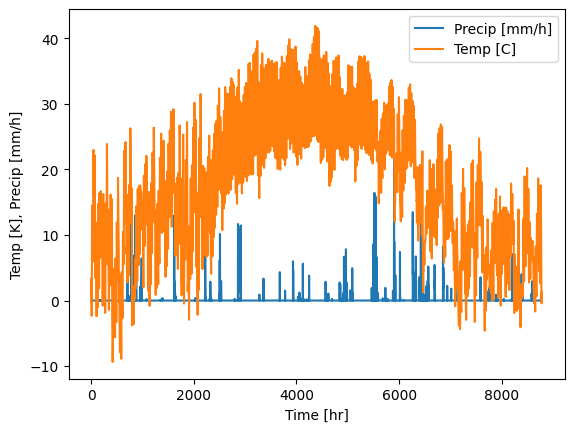

In [32]:
# pull all eight forcing variables for the site and year defined above
# this will save the forcing data to the static_write_dir which will be used to run the PF-CLM model
# the variables are
#DSWR:  Downward Visible or Short-Wave radiation [W/m2]
#DLWR:  Downward Infrared or Long-Wave radiation [W/m2]
#APCP:  Precipitation rate [mm/s]
#Temp:  Air temperature [K]
#UGRD:  West-to-East or U-component of wind [m/s]
#VGRD:  South-to-North or V-component of wind [m/s]
#Press: Atmospheric Pressure [pa]
#SPFH:  Water-vapor specific humidity [kg/kg]

## *Note* the data is saved in a pandas dataframe, and then written to a text file, forcing1D.<site_id>.<startdate>-<enddate>.txt
## **Note** this operation can take several minutes to complete

dataset = "CW3E"
version= "0.8"

options = {"dataset":dataset, "period":"hourly", "variable":"precipitation","start_time":start, "end_time":end, "grid_bounds":bounds, "dataset_version": version}
APCP = hf.get_gridded_data(options) 
print("Precip Loaded:",np.shape(APCP))

options = {"dataset":dataset, "period":"hourly", "variable":"downward_longwave","start_time":start, "end_time":end, "grid_bounds":bounds, "dataset_version": version}
DLWR = hf.get_gridded_data(options) 
print("Longwave Loaded:",np.shape(DLWR))

options = {"dataset":dataset, "period":"hourly", "variable":"downward_shortwave","start_time":start, "end_time":end, "grid_bounds":bounds, "dataset_version": version}
DSWR = hf.get_gridded_data(options) 
print("Shortwave Loaded:",np.shape(DSWR))

options = {"dataset":dataset, "period":"hourly", "variable":"specific_humidity","start_time":start, "end_time":end, "grid_bounds":bounds, "dataset_version": version}
SPFH = hf.get_gridded_data(options)
print("Humidity Loaded:",np.shape(SPFH)) 

options = {"dataset":dataset, "period":"hourly", "variable":"air_temp","start_time":start, "end_time":end, "grid_bounds":bounds, "dataset_version": version}
Temp = hf.get_gridded_data(options) 
print("Air Temp Loaded:",np.shape(Temp))

options = {"dataset":dataset, "period":"hourly", "variable":"east_windspeed","start_time":start, "end_time":end, "grid_bounds":bounds, "dataset_version": version}
UGRD = hf.get_gridded_data(options) 
print("E-W Wind Loaded:",np.shape(UGRD))

options = {"dataset":dataset, "period":"hourly", "variable":"north_windspeed","start_time":start, "end_time":end, "grid_bounds":bounds, "dataset_version": version}
VGRD = hf.get_gridded_data(options) 
print("N-S Wind Loaded:",np.shape(VGRD))

options = {"dataset":dataset, "period":"hourly", "variable":"atmospheric_pressure","start_time":start, "end_time":end, "grid_bounds":bounds, "dataset_version": version}
Press = hf.get_gridded_data(options) 
print("Press Loaded:",np.shape(Press))

#Combine in a Pandas DataFrame

forcing_df = pd.DataFrame({"DSWR [W/m2]":DSWR[:,0,0], "DLWR [W/m2]":DLWR[:,0,0], "APCP [mm/s]":APCP[:,0,0], "Temp [K]":Temp[:,0,0], "UGRD [m/s]":UGRD[:,0,0],"VGRD [m/s]":VGRD[:,0,0],"Press [pa]":Press[:,0,0],"SPFH [kg/kg]":SPFH[:,0,0]})

# write to a file, we need these forcing files to reflect station location / name
#forcing_df.to_csv(static_write_dir+'/forcing1D.'+site_id+'.txt',sep=' ',header=None, index=False, index_label=False,float_format='%.8f')
forcing_df.to_csv(static_write_dir+'/forcing1D.'+site_id+'.'+start+'-'+end+'.txt',sep=' ',header=None, index=False, index_label=False,float_format='%.8f')


# plot the precp and temp to check that the data looks reasonable
plt.plot(forcing_df['APCP [mm/s]']*3600, label='Precip [mm/h]')
plt.plot(forcing_df['Temp [K]']-273.15, label='Temp [C]')
plt.xlabel('Time [hr]')
plt.ylabel('Temp [K], Precip [mm/h]')
plt.legend()
plt.show()
